## Create the graph with added Deep Matches

In [3]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)

%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np

root = Settings['data_root']

#frame = 1
#resize = 0.5

mot16 = MOT16(root)

# the training set contains both detection as well as ground-truth data
# while the test set only contains detection data.
X, Y_det, Y_gt = mot16.get_train("MOT16-02", memmapped=True)

DM = np.load('MOT16_02.npy')

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}
/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded


In [7]:
X, Y_det, Y_gt = mot16.get_train("MOT16-02", memmapped=True)

print("")
print("X:", X.shape)
print("DM:", DM.shape)

MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded

X: (600, 1080, 1920, 3)
DM: (600,)


In [33]:
def get_visible_pedestrains(frame):
    Y_gt_frame1 = utils.extract_eq(Y_gt, col=0, value=frame)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=7, value=1)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=8, value=1)
    return Y_gt_frame1

import numpy as np
from math import sqrt

nbr_frames = 100
X_ = X[0:nbr_frames]

D = []
for i in range(nbr_frames):
    D.append(get_visible_pedestrains(i+1))

D = np.concatenate(D).astype('int64')

def is_inside_bb(bb, u,v):
    x,y,w,h = bb
    return u >= x and u < x+w and \
        v >= y and v < y+h

def calculate_cost(one, two):
    i, pid1, x1, y1, bb_w1, bb_h1, _, _, _ = one
    j, pid2, x2, y2, bb_w2, bb_h2, _, _, _ = two
    
    h = (bb_h1 + bb_h2) / 2.0
    f_st =  sqrt((x1 - x2)**2 + (y1 - y2)**2) / h
    
    f_st += 1e-10
    
    f_dm = 0
    
    if (j - i) >= 30:
        return 0  # we know nothing
    
    
    intersections = 0
    unions = 0

    for M in DM[i][max(j-i-1, 0)]:
        if i == j:    
            inside_one = is_inside_bb((x1,y1,bb_w1,bb_h1), M[0], M[1])
            inside_two = is_inside_bb((x2,y2,bb_w2,bb_h2), M[0], M[1])
        else:
            inside_one = is_inside_bb((x1,y1,bb_w1,bb_h1), M[0], M[1])
            inside_two = is_inside_bb((x2,y2,bb_w2,bb_h2), M[2], M[3])

        if inside_one and inside_two:
            intersections += 1
        if inside_one or inside_two:
            unions += 1

    if unions > 0:
        f_dm = intersections/unions
    else:
        f_dm = 0.5
    
    if not f_dm > 0:
        f_dm = 0.000000001
    
    
    #ce = - np.log((1- np.exp(-f_st))/np.exp(-f_st))
    
    ce = np.log(f_dm / (1.000000001 - f_dm))
    
    return ce
        

def calculate_adj_list(Table, dst_theta=3):
    n, _ = Table.shape
    
    edges = []
    lifted_edges = []
    
    ALL_EDGES = []
    
    for i, entry in enumerate(Table):
        f, pid, bb_left, bb_right, bb_w, bb_h, _, _, _ = entry
        
        for j in range(i+1, n):
            f_o, pid_o, bb_left_o, bb_right_o, bb_w_o, bb_h_o, _, _, _ = Table[j]
            
            cost = calculate_cost(entry, Table[j])
            #print('cost:', cost)
            #cost = 10 if pid == pid_o else -1
            
            if abs(f_o - f) > dst_theta:
                # lifted edge
                lifted_edges.append((i,j,cost))
            else:
                # normal edge
                edges.append((i,j,cost))
            
            ALL_EDGES.append((i, j, cost))
                
    edges = np.array(edges)
    lifted_edges = np.array(lifted_edges)
    ALL_EDGES = np.array(ALL_EDGES)
    
    print('Edges', edges.shape)
    print('Lifted Edges', lifted_edges.shape)
    
    fmt = '%d %d %f'
    
    np.savetxt('edges.txt', edges, delimiter=';', fmt=fmt)
    np.savetxt('lifted_edges.txt', lifted_edges, delimiter=';', fmt=fmt)
    
    with open('config.txt', 'w+') as f:
        print(str(n), file=f)
        
    return ALL_EDGES
    
                
print(D.shape)
ALL_EDGES = calculate_adj_list(D)
#print(D)

(579, 9)
Edges (11774, 3)
Lifted Edges (155557, 3)


unique: 19


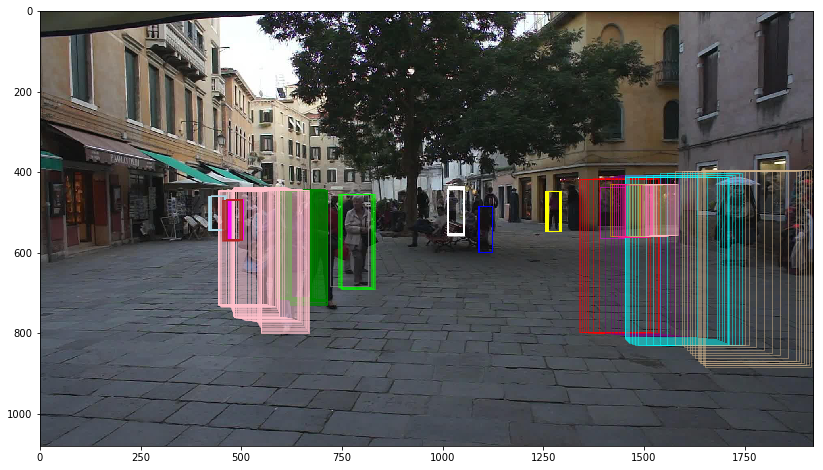

In [37]:
from numpy import genfromtxt
from matplotlib.colors import get_named_colors_mapping

ALL_COLORS = list(get_named_colors_mapping().keys())

result = genfromtxt('build/result.txt', delimiter=' ', dtype='uint32')

def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes
            
        

Nodes = extract_ids(result)

def get_bb(i, D):
    left = D[i,2]
    top = D[i,3]
    width = D[i,4]
    height = D[i,5]
    return left, top, width, height

def get_line(i, j, D):
    x1,y1,w1,h1 = get_bb(i, D)
    x2,y2,w2,h2 = get_bb(j, D)
    
    center = lambda x,y,w,h: (x+(w/2), y+(h/2))
    
    A = center(x1,y1,w1,h1)
    B = center(x2,y2,w2,h2)
    return [A[0], B[0]], [A[1], B[1]]


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(X_[-1])


ALL_COLORS = [
    'red', 'green', 'blue', 'yellow', 'pink', 
    'purple', 'white', 'magenta', 'cyan', 'lightblue',
    'orange', 'deeppink', 'tan', 'darkkhaki', 'lightpink',
    'magenta', 'darkgrey', 'firebrick', 'lime', 'corneflowerblue']

print("unique:", len(np.unique(Nodes)))

color_lookup = {}
for i,N in enumerate(np.unique(Nodes)):
    color_lookup[str(N)] = ALL_COLORS[i]

for i, node in enumerate(Nodes):
    l,t,w,h = get_bb(i, D)
    bbX, bbY = utils.bb_to_plt_plot(l, t, w, h)
    ax.plot(bbX, bbY, linewidth=1, color=color_lookup[str(Nodes[i])], alpha=0.5)

plt.show()